# Prediction of drug release using XGBoost-Time 
## Initialize environment and variables
There are 321 samples in the Bao et al (2025) dataset, we use 12 input features (11 material/formulation, 1 time) from the dataset. Our approach normalizes and interpolates the release curve prior to prediction. The XGB-Time model's hyperparameters and optimized using 10x2 cross validation and 50 Optuna trials per fold. 

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import xgboost as xgb
from optuna.samplers import TPESampler
import warnings
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore")

# ----------------------------------------------------------------------------------------
# Setup
# ----------------------------------------------------------------------------------------
total_samples = 321
num_interp_pts = 11
num_features = 12
n_outer_folds = 10
n_inner_folds = 2
n_trials = 50

model_name = "XGBoost"
inner_loss_filename = f"{model_name}_inner_loss.csv"
outer_loss_filename = f"{model_name}_outer_loss.csv"
inputs_filename = f"{model_name}_inputs.csv"
preds_filename = f"{model_name}_preds_vs_targets.csv"
metrics_filename = f"{model_name}_metrics_summary.csv"

# ----------------------------------------------------------------------------------------
# Load data
# ----------------------------------------------------------------------------------------
file_path_form = 'mp_dataset_processed_no_dupes.xlsx'
file_path_time = 'mp_dataset_processed_time_release_only.xlsx'
form_df = pd.read_excel(file_path_form, engine='openpyxl')
release_df = pd.read_excel(file_path_time, engine='openpyxl')

## Data preparation
Dataframe input encoding, drug release curve interpolation and normalization. Duplcation of input features and insertion of time column. 

In [11]:
# ----------------------------------------------------------------------------------------
# Encode categorical
# ----------------------------------------------------------------------------------------
unique_values_emulsion = form_df['Formulation Method'].unique()
mapping = {v: i for i, v in enumerate(unique_values_emulsion)}
form_df['Formulation Method Encoded'] = form_df['Formulation Method'].map(mapping)
form_df.drop(columns=['Formulation Method', 'Drug SMILES'], inplace=True)
# ----------------------------------------------------------------------------------------
# Define feature names before interpolation
# ----------------------------------------------------------------------------------------
feature_names = form_df.drop(columns=['Formulation Index']).columns.tolist()
# ----------------------------------------------------------------------------------------
# Interpolation
# ----------------------------------------------------------------------------------------
group = release_df.groupby('Formulation Index')['Time']
min_time = group.transform('min')
max_time = group.transform('max')
release_df['Normalized Time'] = (release_df['Time'] - min_time) / (max_time - min_time)
normalized_times = np.linspace(0, 1, num_interp_pts)
interpolated_dfs = []
for formulation, g in release_df.groupby('Formulation Index'):
    g = g.sort_values('Time')
    time_min, time_max = g['Time'].min(), g['Time'].max()
    g['Normalized Time'] = (g['Time'] - time_min) / (time_max - time_min)
    interp_release = np.interp(normalized_times, g['Normalized Time'], g['Release'])
    interpolated_dfs.append(pd.DataFrame({
        'Formulation Index': formulation,
        'Normalized Time': normalized_times,
        'Interpolated Release': interp_release
    }))
interp_df = pd.concat(interpolated_dfs, ignore_index=True)
repeated_df = form_df.loc[form_df.index.repeat(num_interp_pts)].reset_index(drop=True)
repeated_df['Normalized Time'] = interp_df['Normalized Time']
# ----------------------------------------------------------------------------------------
# Add 'Normalized Time' to feature names
# ----------------------------------------------------------------------------------------
feature_names.append('Normalized Time')

X = repeated_df.drop(columns=['Formulation Index']).to_numpy()
y = interp_df['Interpolated Release'].to_numpy()
group_size = num_interp_pts
num_groups = len(X) // group_size
groups = np.repeat(np.arange(num_groups), group_size)

# Model definition and optimization

In [15]:
# ----------------------------------------------------------------------------------------
# XGBoost-Time wrapper
# ----------------------------------------------------------------------------------------
class XGBoostModel:
    def __init__(self, **params):
        self.model = xgb.XGBRegressor(**params, tree_method='hist', random_seed=42, enable_categorical=True)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse

# ----------------------------------------------------------------------------------------
# Storage
# ----------------------------------------------------------------------------------------
stored_best_models = []
stored_best_preds = []
stored_X_test = []
stored_test_targets = []
stored_best_rmse = []
stored_best_mse = []
stored_r2 = []
stored_adj_r2 = []
all_outer_train_loss_curves_best = []
stored_test_indices = []

# ----------------------------------------------------------------------------------------
# Nested CV
# ----------------------------------------------------------------------------------------
outer_kf = GroupKFold(n_splits=n_outer_folds)
inner_kf = GroupKFold(n_splits=n_inner_folds)

# ----------------------------------------------------------------------------------------
# Outer CV loop
# ----------------------------------------------------------------------------------------
for outer_fold, (train_val_idx, test_idx) in enumerate(outer_kf.split(X, y, groups)):
    print(f"\nOuter Fold {outer_fold + 1}")
    X_train_val, y_train_val = X[train_val_idx], y[train_val_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    stored_X_test.append(X_test)
    stored_test_targets.append(y_test)
    stored_test_indices.append(test_idx)

    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 1)
        }
        val_losses, train_losses = [], []
        for train_idx, val_idx in inner_kf.split(X_train_val, y_train_val, groups[train_val_idx]):
            X_tr, X_val = X_train_val[train_idx], X_train_val[val_idx]
            y_tr, y_val = y_train_val[train_idx], y_train_val[val_idx]
            model = XGBoostModel(**params)
            model.fit(X_tr, y_tr)
            val_loss = model.evaluate(X_val, y_val)
            val_losses.append(val_loss)
            train_loss = model.evaluate(X_tr, y_tr)
            train_losses.append(train_loss)
        return np.mean(val_losses)

    # ----------------------------------------------------------------------------------------
    # Run Optuna study
    # ----------------------------------------------------------------------------------------
    tpe_sampler = TPESampler(seed=42) 
    study = optuna.create_study(direction="minimize", sampler=tpe_sampler)
    study.optimize(objective, n_trials=n_trials)
    best_params = study.best_params
    print("Best params:", best_params)
    
    # ----------------------------------------------------------------------------------------
    # Train best model on full training data
    # ----------------------------------------------------------------------------------------
    best_model = XGBoostModel(**best_params)
    best_model.fit(X_train_val, y_train_val)
    
    # ----------------------------------------------------------------------------------------
    # Compute classification metrics
    # ----------------------------------------------------------------------------------------
    preds_best = best_model.predict(X_test)
    mse_best = mean_squared_error(y_test, preds_best)
    rmse_best = np.sqrt(mse_best)
    r2 = r2_score(y_test, preds_best)
    n, p = X_test.shape
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    stored_best_models.append(best_model)
    stored_best_preds.append(preds_best)
    stored_best_mse.append(mse_best)
    stored_best_rmse.append(rmse_best)
    stored_r2.append(r2)
    stored_adj_r2.append(adj_r2)
    all_outer_train_loss_curves_best.append([mse_best])

    print(f"Fold {outer_fold+1} RMSE: {rmse_best:.4f}, Adj R²: {adj_r2:.4f}")

print(f"\nFinal Nested CV RMSE: {np.mean(stored_best_rmse):.3f} ± {np.std(stored_best_rmse):.3f}")
print(f"\nFinal Adj R²: {np.mean(stored_adj_r2):.2f} ± {np.std(stored_adj_r2):.2f}")


Outer Fold 1
Best params: {'max_depth': 8, 'learning_rate': 0.07335392129197696, 'n_estimators': 225, 'subsample': 0.6582436629642097, 'colsample_bytree': 0.6377102108944628, 'gamma': 0.0185146037839148, 'reg_alpha': 0.19123741463533572, 'reg_lambda': 0.5624478986539984}
Fold 1 RMSE: 0.1360, Adj R²: 0.8086

Outer Fold 2
Best params: {'max_depth': 10, 'learning_rate': 0.2597961683861477, 'n_estimators': 101, 'subsample': 0.7345333714668801, 'colsample_bytree': 0.7740106166754568, 'gamma': 0.008554418542379844, 'reg_alpha': 0.5619379761711434, 'reg_lambda': 0.7435774757558886}
Fold 2 RMSE: 0.1352, Adj R²: 0.8027

Outer Fold 3
Best params: {'max_depth': 9, 'learning_rate': 0.17602818531909714, 'n_estimators': 90, 'subsample': 0.7595215929204131, 'colsample_bytree': 0.7771046292181767, 'gamma': 0.01772129107100514, 'reg_alpha': 0.43169444811975083, 'reg_lambda': 0.5259619361656294}
Fold 3 RMSE: 0.1427, Adj R²: 0.7802

Outer Fold 4
Best params: {'max_depth': 13, 'learning_rate': 0.04057760

# Visualize predictions

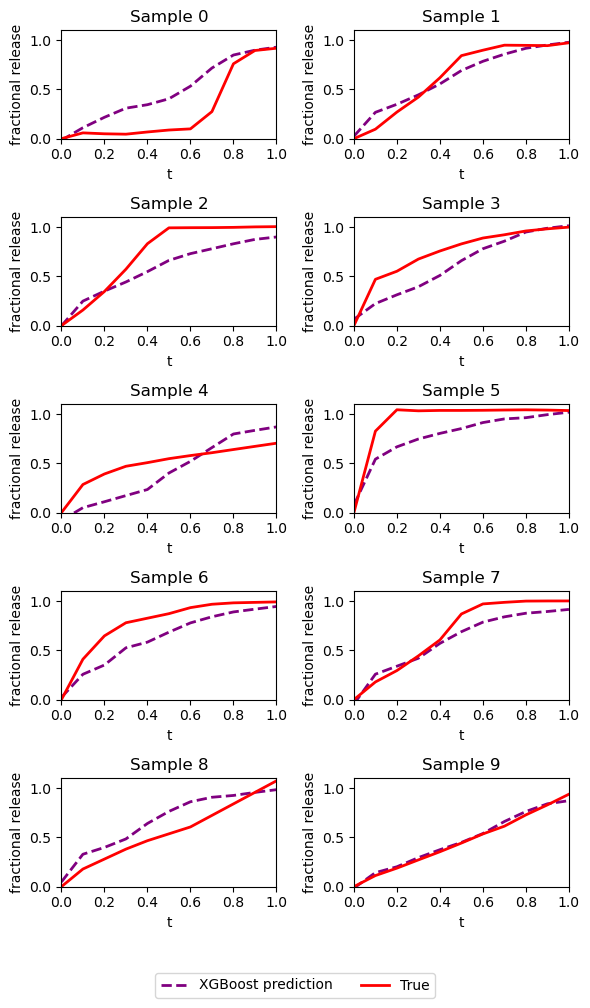

In [16]:
# ----------------------
# Plot example predictions
# ----------------------
x = np.linspace(0, 1, num_interp_pts)
fig, axes = plt.subplots(5, 2, figsize=(6, 10))  # 10 samples total
axes = axes.flatten()

# Plot first 10 samples from the first outer fold
for i in range(10):
    # Each sample spans num_interp_pts consecutive values
    start = i * num_interp_pts
    end = (i + 1) * num_interp_pts

    line1, = axes[i].plot(
        x, stored_best_preds[0][start:end],
        label=f"{model_name} prediction", linestyle='--', lw=2, color='purple'
    )
    line2, = axes[i].plot(
        x, stored_test_targets[0][start:end],
        label="True", linestyle='-', lw=2, color='red'
    )
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("t")
    axes[i].set_ylabel("fractional release")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1.1)

# Add global legend below all plots
fig.legend(
    handles=[line1, line2],
    labels=[f"{model_name} prediction", "True"],
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.01)
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave room for legend
plot_filename = f"{model_name}_prediction.png"
plt.savefig(plot_filename, dpi=300, bbox_inches="tight")
plt.show()

# Store model metrics, inputs, predictions

In [17]:
# Outer loss
outer_records = []
for fold_idx, train_losses in enumerate(all_outer_train_loss_curves_best, start=1):
    for epoch, tr in enumerate(train_losses, start=1):
        outer_records.append({"outer_fold": fold_idx, "epoch": epoch, "train_loss": tr})
#pd.DataFrame(outer_records).to_csv(outer_loss_filename, index=False)

# Inputs (X_test)
input_records = []
for fold_idx, X_test_fold in enumerate(stored_X_test, start=1):
    for i in range(X_test_fold.shape[0]):
        record = {"outer_fold": fold_idx, "index_in_fold": i}
        # Add each feature as a column
        for j, feature_name in enumerate(feature_names):
            record[feature_name] = X_test_fold[i, j]
        input_records.append(record)
#pd.DataFrame(input_records).to_csv(inputs_filename, index=False)

# Predictions (y_pred and y_true)
pred_records = []
for fold_idx, (preds, targets) in enumerate(zip(stored_best_preds, stored_test_targets), start=1):
    for i in range(len(preds)):
        pred_records.append({"outer_fold": fold_idx, "index_in_fold": i, "y_true": targets[i], "y_pred": preds[i]})
pd.DataFrame(pred_records).to_csv(preds_filename, index=False)

# Metrics
metrics_records = []
for fold_idx, (mse, rmse, r2, adj_r2) in enumerate(zip(stored_best_mse, stored_best_rmse, stored_r2, stored_adj_r2), start=1):
    metrics_records.append({"outer_fold": fold_idx, "MSE": mse, "RMSE": rmse, "R2": r2, "Adj_R2": adj_r2})
df_metrics = pd.DataFrame(metrics_records)
df_metrics.loc["mean"] = df_metrics.mean(numeric_only=True)
df_metrics.loc["std"] = df_metrics.std(numeric_only=True)
df_metrics.to_csv(metrics_filename)

#print(f"\nSaved {outer_loss_filename}, {inputs_filename}, {preds_filename}, {metrics_filename}")